# PKS Upgrade

This notebook documents the tests I ran to determine the behaviour of a PKS managed Kubernetes cluster during a planned upagrade. Testing was done against a Toolsmiths provisioned cluster (v1.5) using JMeter to direct a moderate load to pods running on the cluster. Pods were exposed using a Service `type: Load Balancer`.

Summary:

* 6 pods, on 3 nodes
* 1 master
* Kubernetes 1.14
* PKS 1.5
* Downtime observed during the upgrade
* As yet unable to explain the downtime

Next Steps:

* Re-run with 3 pods, 3 nodes (to simplify analysis)
* Capture output of `kubectl get pods -o wide` during the test
* Reduce the timeout on JMeter requests


![PKS Cluster](cluster.png)

## Deloyment

```yaml
---
apiVersion: v1
kind: Service
metadata:
  name: hello
spec:
  type: LoadBalancer
  ports:
  - port: 80
    targetPort: 8080
  selector:
    app: hello

---
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello
  labels:
    app: hello
spec:
  replicas: 6
  selector:
    matchLabels:
      app: hello
  template:
    metadata:
      labels:
        app: hello
    spec:
      containers:
      - name: hello
        image: billglover/hello
        ports:
        - containerPort: 8080

```

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas

In [272]:
df = pandas.read_csv('results.csv', header=0, index_col=0, parse_dates=True, date_parser=lambda epoch: pandas.to_datetime(epoch, unit='ms'), low_memory=False)

In [273]:
df.iloc[:10]

elapsed         label responseCode responseMessage  \
timeStamp                                                                     
2019-11-01 10:55:32.611     60.0  HTTP Request          200              OK   
2019-11-01 10:55:32.600     84.0  HTTP Request          200              OK   
2019-11-01 10:55:32.611     61.0  HTTP Request          200              OK   
2019-11-01 10:55:32.608     76.0  HTTP Request          200              OK   
2019-11-01 10:55:32.608     72.0  HTTP Request          200              OK   
2019-11-01 10:55:32.599     85.0  HTTP Request          200              OK   
2019-11-01 10:55:32.612     68.0  HTTP Request          200              OK   
2019-11-01 10:55:32.612     59.0  HTTP Request          200              OK   
2019-11-01 10:55:32.619     61.0  HTTP Request          200              OK   
2019-11-01 10:55:32.716      5.0  HTTP Request          200              OK   

                                threadName dataType success  failureMessage  \
timeStamp                                                                     
2019-11-01 10:55:32.611   Thread Group 1-3     text    True             NaN   
2019-11-01 10:55:32.600   Thread Group 1-2     text    True             NaN   
2019-11-01 10:55:32.611   Thread Group 1-4     text    True             NaN   
2019-11-01 10:55:32.608   Thread Group 1-8     text    True             NaN   
2019-11-01 10:55:32.608   Thread Group 1-1     text    True             NaN   
2019-11-01 10:55:32.599   Thread Group 1-6     text    True             NaN   
2019-11-01 10:55:32.612   Thread Group 1-5     text    True             NaN   
2019-11-01 10:55:32.612   Thread Group 1-7     text    True             NaN   
2019-11-01 10:55:32.619   Thread Group 1-9     text    True             NaN   
2019-11-01 10:55:32.716  Thread Group 1-12     text    True             NaN   

                         bytes  sentBytes  grpThreads  allThreads  \
timeStamp                                                           
2019-11-01 10:55:32.611  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.600  755.0      116.0        11.0        11.0   
2019-11-01 10:55:32.611  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.608  755.0      116.0        11.0        11.0   
2019-11-01 10:55:32.608  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.599  755.0      116.0        11.0        11.0   
2019-11-01 10:55:32.612  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.612  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.619  755.0      116.0        10.0        10.0   
2019-11-01 10:55:32.716  755.0      116.0        12.0        12.0   

                                          URL  Latency  IdleTime  Connect  \
timeStamp                                                                   
2019-11-01 10:55:32.611  http://35.240.26.39/     60.0       0.0     35.0   
2019-11-01 10:55:32.600  http://35.240.26.39/     84.0       0.0     45.0   
2019-11-01 10:55:32.611  http://35.240.26.39/     61.0       0.0     34.0   
2019-11-01 10:55:32.608  http://35.240.26.39/     76.0       0.0     39.0   
2019-11-01 10:55:32.608  http://35.240.26.39/     72.0       0.0     38.0   
2019-11-01 10:55:32.599  http://35.240.26.39/     85.0       0.0     48.0   
2019-11-01 10:55:32.612  http://35.240.26.39/     68.0       0.0     34.0   
2019-11-01 10:55:32.612  http://35.240.26.39/     59.0       0.0     34.0   
2019-11-01 10:55:32.619  http://35.240.26.39/     61.0       0.0     27.0   
2019-11-01 10:55:32.716  http://35.240.26.39/      5.0       0.0      3.0   

                                           pod  
timeStamp                                       
2019-11-01 10:55:32.611  hello-cd6cdcc9b-f8d65  
2019-11-01 10:55:32.600  hello-cd6cdcc9b-ddj66  
2019-11-01 10:55:32.611  hello-cd6cdcc9b-wjtbf  
2019-11-01 10:55:32.608  hello-cd6cdcc9b-gdrqq  
2019-11-01 10:55:32.608  hello-cd6cdcc9b-pq8mq  
2019-11-01 10:55:32.599  hello

In [274]:
dfs = df.iloc[:, [2,16]]

In [275]:
dfok = dfs[dfs.responseCode == '200']
dfok

responseCode                    pod
timeStamp                                                  
2019-11-01 10:55:32.611          200  hello-cd6cdcc9b-f8d65
2019-11-01 10:55:32.600          200  hello-cd6cdcc9b-ddj66
2019-11-01 10:55:32.611          200  hello-cd6cdcc9b-wjtbf
2019-11-01 10:55:32.608          200  hello-cd6cdcc9b-gdrqq
2019-11-01 10:55:32.608          200  hello-cd6cdcc9b-pq8mq
...                              ...                    ...
2019-11-01 11:30:29.133          200  hello-cd6cdcc9b-rc8f5
2019-11-01 11:30:29.130          200  hello-cd6cdcc9b-rc8f5
2019-11-01 11:30:29.132          200  hello-cd6cdcc9b-rc8f5
2019-11-01 11:30:29.132          200  hello-cd6cdcc9b-2ltxn
2019-11-01 11:30:29.132          200  hello-cd6cdcc9b-2ltxn

[11303090 rows x 2 columns]

In [269]:
dfg = dfok.groupby(['pod', pandas.Grouper(freq='S')])['responseCode'].count()

In [268]:
pods = dfg.index.get_level_values(0).unique()

In [300]:
xmin, xmax = dfg.index.get_level_values(1).min(), dfg.index.get_level_values(1).max()

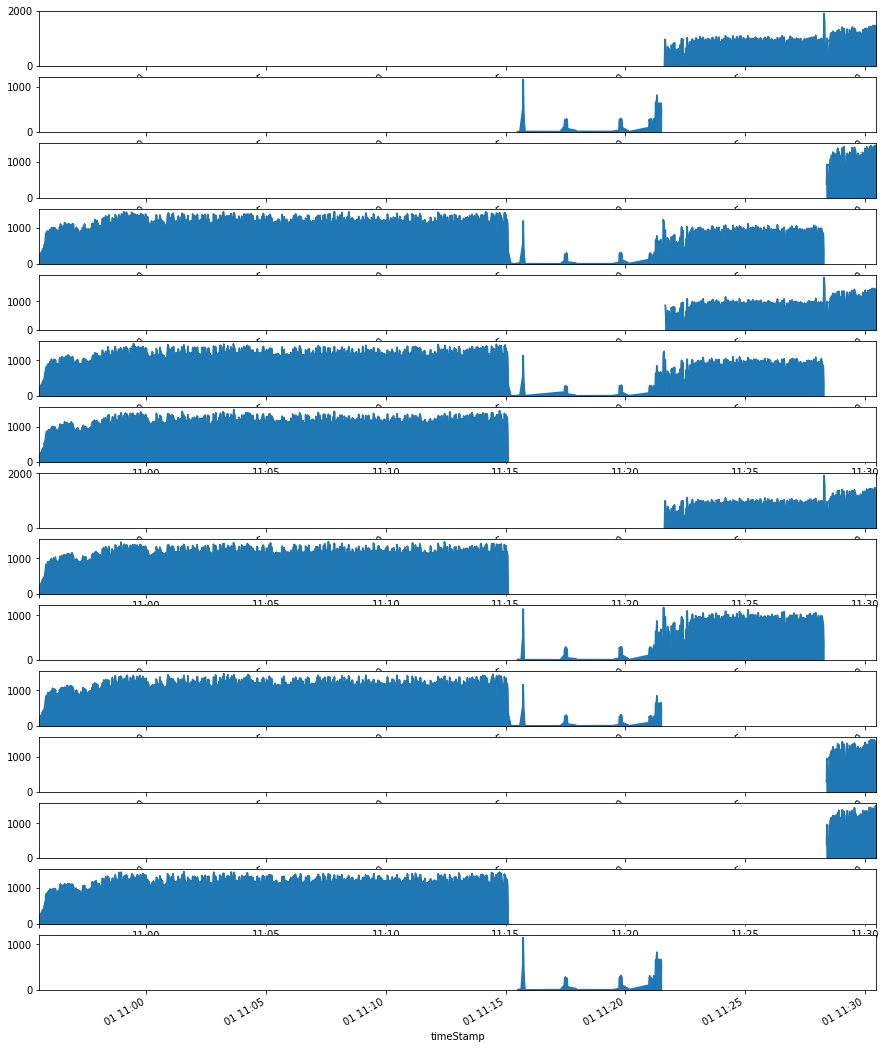

In [263]:
fig, ax = plt.subplots(len(pods), figsize=(15,20))

for idx, pod_name in enumerate(pods):
    dfg.loc[pod_name].plot.area(ax=ax[idx])
    ax[idx].set_xlim([xmin, xmax])

In [ ]:
for idx, pod_name in enumerate(pods):
    plt.figure()
    ax = dfg.loc[pod_name].plot()
    ax.set_xlim([xmin, xmax])

In [ ]:
pod_count = len(dfg.index.get_level_values(0).unique())
fig, ax = plt.subplots(pod_count, figsize=(10,10), sharex=True)
for idx, data in enumerate(dfg.groupby("pod")):
    data[1].unstack().plot(ax=ax[idx])


In [306]:
dfgs = dfg.swaplevel()
dfgs

timeStamp            pod                  
2019-11-01 11:21:38  hello-cd6cdcc9b-2ltxn      1
2019-11-01 11:21:39  hello-cd6cdcc9b-2ltxn    800
2019-11-01 11:21:40  hello-cd6cdcc9b-2ltxn    966
2019-11-01 11:21:41  hello-cd6cdcc9b-2ltxn    582
2019-11-01 11:21:42  hello-cd6cdcc9b-2ltxn    126
                                             ... 
2019-11-01 11:21:26  hello-cd6cdcc9b-xvh4v    533
2019-11-01 11:21:27  hello-cd6cdcc9b-xvh4v    435
2019-11-01 11:21:28  hello-cd6cdcc9b-xvh4v    398
2019-11-01 11:21:29  hello-cd6cdcc9b-xvh4v    667
2019-11-01 11:21:30  hello-cd6cdcc9b-xvh4v    593
Name: responseCode, Length: 10572, dtype: int64

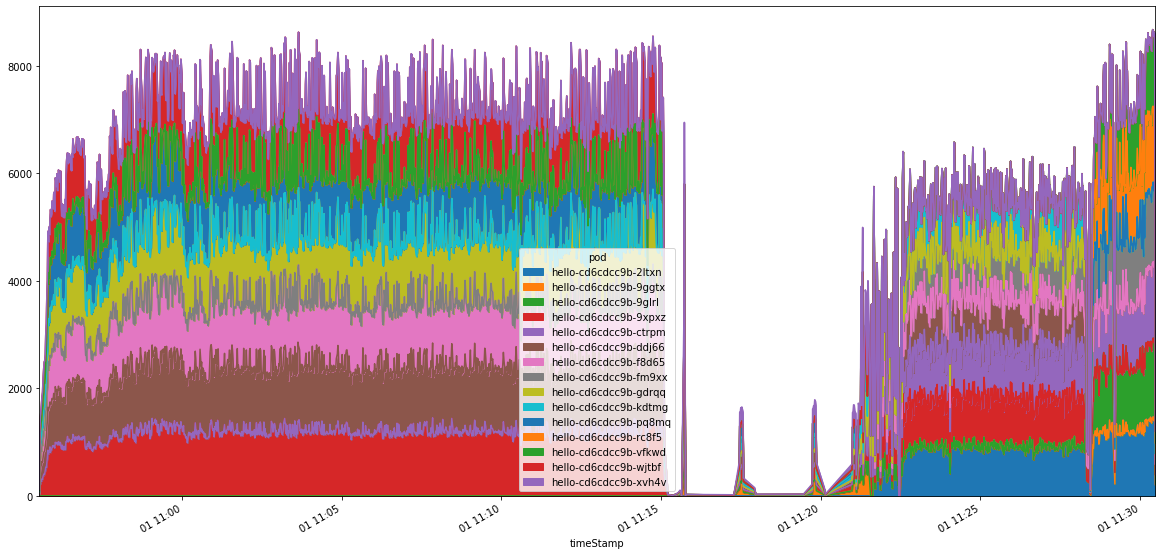

In [307]:
dfgs.unstack().plot.area(figsize=(20,10))

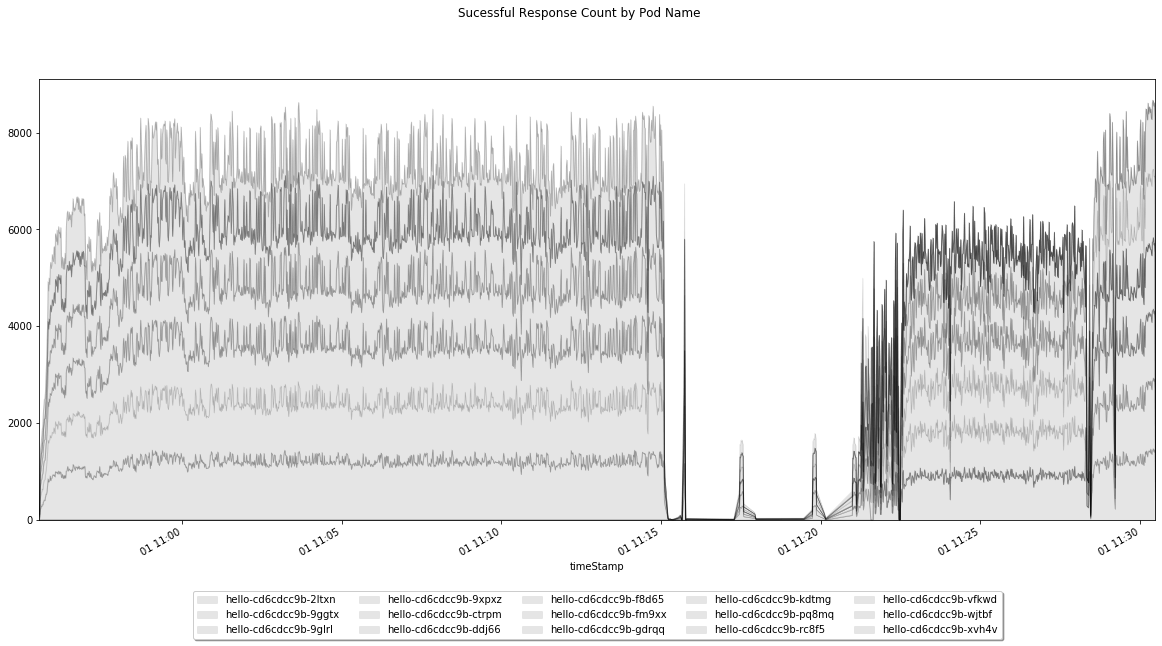

In [314]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
dfgs.unstack().plot.area(ax=ax, stacked=True, color='k', alpha=0.1, linewidth=0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.suptitle('Sucessful Response Count by Pod Name');

In [276]:
dfe = dfs[dfs.responseCode != '200']
dfe

responseCode  \
timeStamp                                                                    
2019-11-01 11:15:06.089   Non HTTP response code: java.net.SocketException   
2019-11-01 11:15:06.102   Non HTTP response code: java.net.SocketException   
2019-11-01 11:15:06.094   Non HTTP response code: java.net.SocketException   
2019-11-01 11:15:06.097   Non HTTP response code: java.net.SocketException   
2019-11-01 11:15:06.161  Non HTTP response code: org.apache.http.conn.H...   
...                                                                    ...   
2019-11-01 11:29:10.788   Non HTTP response code: java.net.SocketException   
2019-11-01 11:29:10.787   Non HTTP response code: java.net.SocketException   
2019-11-01 11:29:10.786   Non HTTP response code: java.net.SocketException   
2019-11-01 11:27:58.093  Non HTTP response code: org.apache.http.conn.H...   
1970-07-02 00:21:18.291                                                NaN   

                             pod  
timeStamp                         
2019-11-01 11:15:06.089  unknown  
2019-11-01 11:15:06.102  unknown  
2019-11-01 11:15:06.094  unknown  
2019-11-01 11:15:06.097  unknown  
2019-11-01 11:15:06.161  unknown  
...                          ...  
2019-11-01 11:29:10.788  unknown  
2019-11-01 11:29:10.787  unknown  
2019-11-01 11:29:10.786  unknown  
2019-11-01 11:27:58.093  unknown  
1970-07-02 00:21:18.291      NaN  

[3548 rows x 2 columns]

In [318]:
dfe['responseCode'].value_counts()

Non HTTP response code: org.apache.http.conn.HttpHostConnectException    2937
Non HTTP response code: java.net.NoRouteToHostException                   565
Non HTTP response code: java.net.SocketException                           45
Name: responseCode, dtype: int64

In [282]:
dfge = dfe.groupby(['pod', pandas.Grouper(freq='S')])['responseCode'].count()

(737364.4552314815, 737364.4795023148)

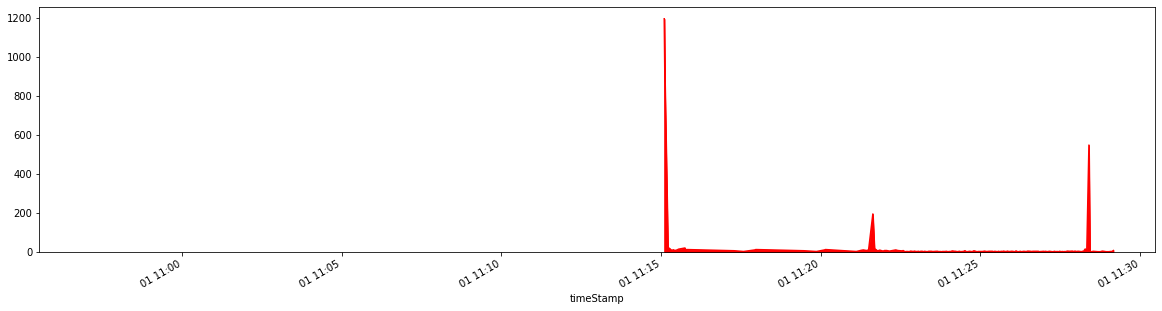

In [304]:
plt.figure(figsize=(20,5))
ax = dfge.loc['unknown'].plot.area(color='r')
ax.set_xlim([xmin, xmax])